In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys

sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')
import numpy as np
import networkx as nx

from src.stats import Stats
from src.models.Frobenius import Frobenius
from src.models.Procustes import Procustes
from src.models.DeltaCon import DeltaCon
from src.models.WL import WL

import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def distance_eigen(A1, A2):
    """Calculate distance between graphs based on maximum eigenvalues.
    
    Args:
        A1: First adjacency matrix
        A2: Second adjacency matrix
        
    Returns:
        float: Euclidean distance between maximum eigenvalues
    """
    # Calculate max eigenvalues
    eig1 = np.max(np.linalg.eigvalsh(A1))
    eig2 = np.max(np.linalg.eigvalsh(A2))
    
    # Return Euclidean distance
    return np.sqrt((eig1 - eig2)**2)

n_nodes = 100  # number of nodes
n_graphs = 10  # number of graphs to generate for each probability
p_values = np.linspace(0.1, 0.9, 9)  # different probability values
n_experiments = 10  # number of times to repeat each comparison

# Initialize results dictionary
results = {
    'Frobenius': [],
    'Procrustes': [],
    'DeltaCon': [],
    'WL': [],
    'Eigen': [],
    'p_values': [],
}



In [23]:
# Run experiments
for p1 in p_values:
    print(f'p = {p1}')
    for j in range(n_experiments):
        print(f'Experiment {j}')
        # Generate two random graphs with same probability
        G1 = nx.erdos_renyi_graph(n_nodes, p1)
        G2 = nx.erdos_renyi_graph(n_nodes, p1)
        
        # Convert to adjacency matrices
        A1 = nx.to_numpy_array(G1)
        A2 = nx.to_numpy_array(G2)
        
        # Calculate distances
        frob_dist = distance_frobenius(A1, A2)
        proc_dist = distance_procrustes_LE(A1, A2, k=10)
        delta_dist = DeltaConDistance(A1, A2)
        wl_dist = WL_distance(A1, A2, n_iter=5)
        eigen_dist = distance_eigen(A1, A2)
        
        # Store results
        results['Frobenius'].append(frob_dist)
        results['Procrustes'].append(proc_dist)
        results['DeltaCon'].append(delta_dist)
        results['WL'].append(wl_dist)
        results['Eigen'].append(eigen_dist)
        results['p_values'].append(p1)


p = 0.1
Experiment 0


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.2
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.30000000000000004
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.4
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.5
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.6
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.7000000000000001
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.8
Experiment 0
Exp

In [24]:
import pickle
with open(f'results_n_{n_nodes}.pkl', 'wb') as f:
    pickle.dump(results, f)


In [25]:
import pandas as pd
df = pd.DataFrame(results)


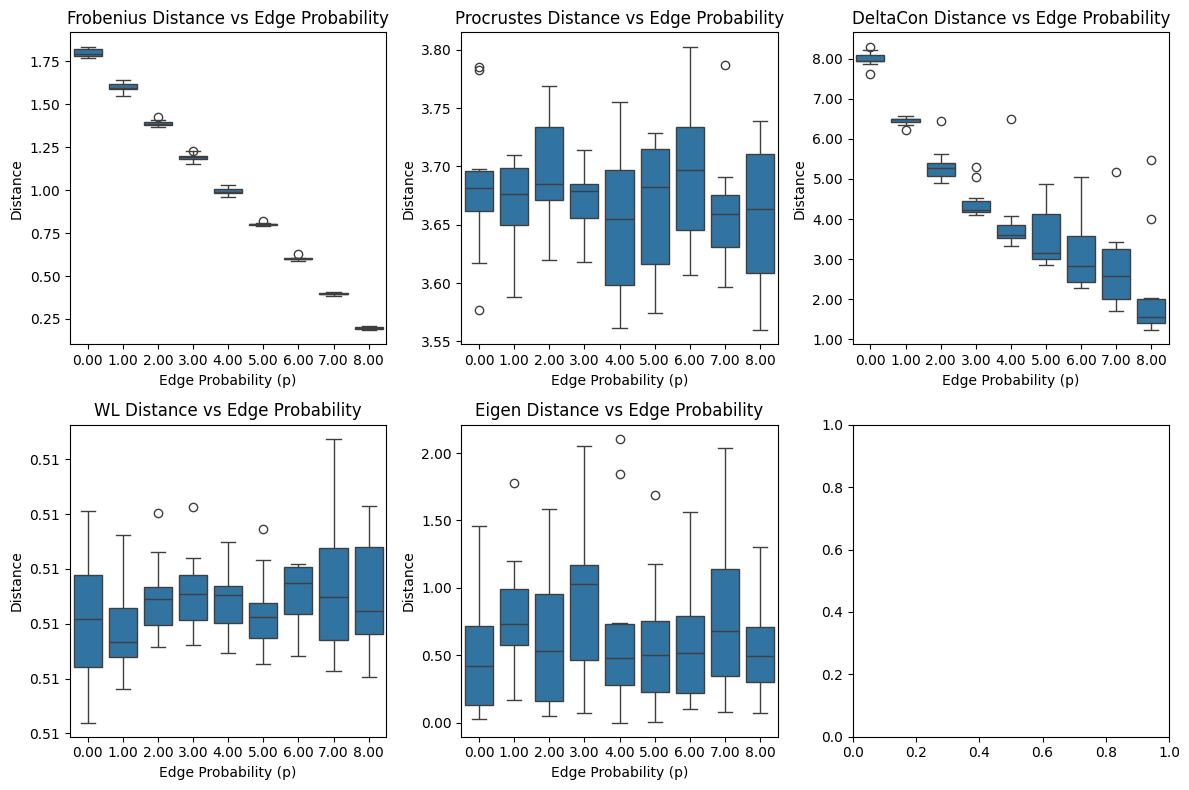

In [27]:
# Plot results
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, metric in enumerate(['Frobenius', 'Procrustes', 'DeltaCon', 'WL', 'Eigen']):
    sns.boxplot(x='p_values', y=metric, data={
        'p_values': results['p_values'],
        metric: results[metric]
    }, ax=axes[i])
    axes[i].set_title(f'{metric} Distance vs Edge Probability')
    axes[i].set_xlabel('Edge Probability (p)')
    axes[i].set_ylabel('Distance')
    axes[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    axes[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

plt.tight_layout()
plt.show()


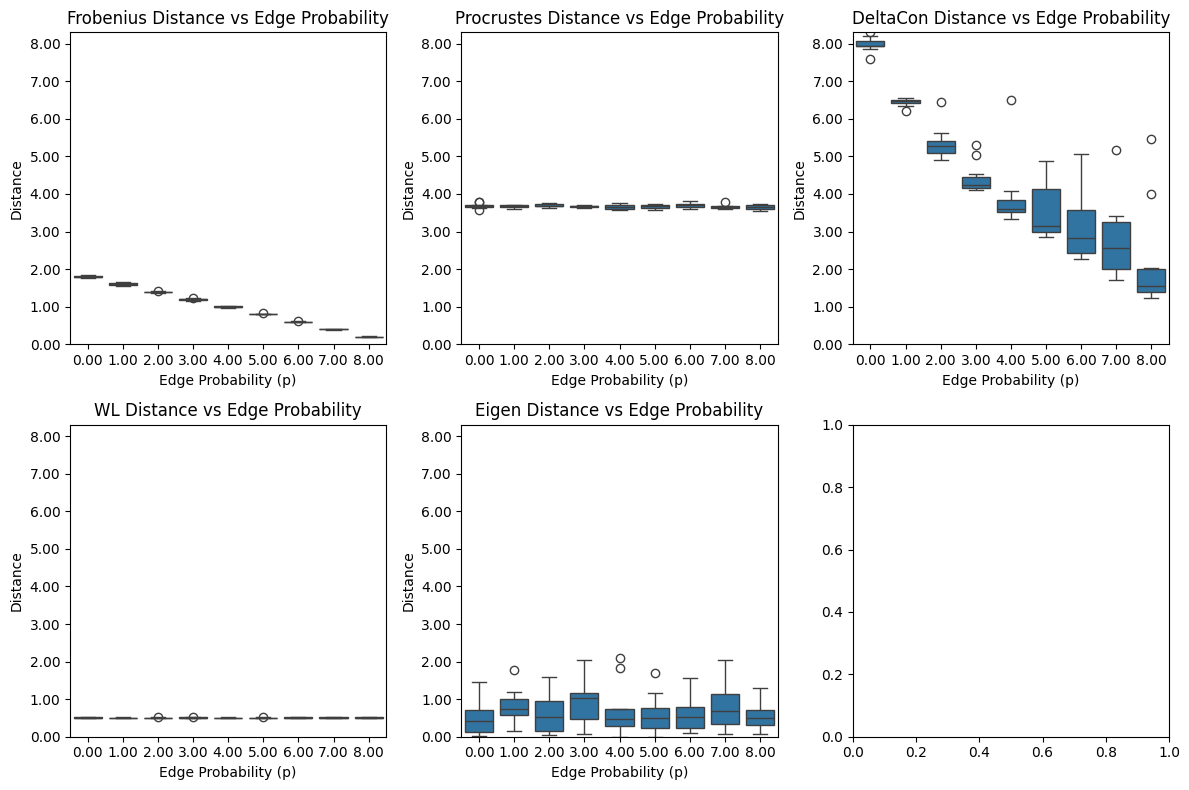

In [28]:
# Plot results
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

# Find the maximum value across all metrics
max_value = max([
    max(results['Frobenius']),
    max(results['Procrustes']), 
    max(results['DeltaCon']),
    max(results['WL']),
    max(results['Eigen'])
])

for i, metric in enumerate(['Frobenius', 'Procrustes', 'DeltaCon', 'WL', 'Eigen']):
    sns.boxplot(x='p_values', y=metric, data={
        'p_values': results['p_values'],
        metric: results[metric]
    }, ax=axes[i])
    axes[i].set_title(f'{metric} Distance vs Edge Probability')
    axes[i].set_xlabel('Edge Probability (p)')
    axes[i].set_ylabel('Distance')
    axes[i].set_ylim(0, max_value)
    axes[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    axes[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

plt.tight_layout()
plt.show()


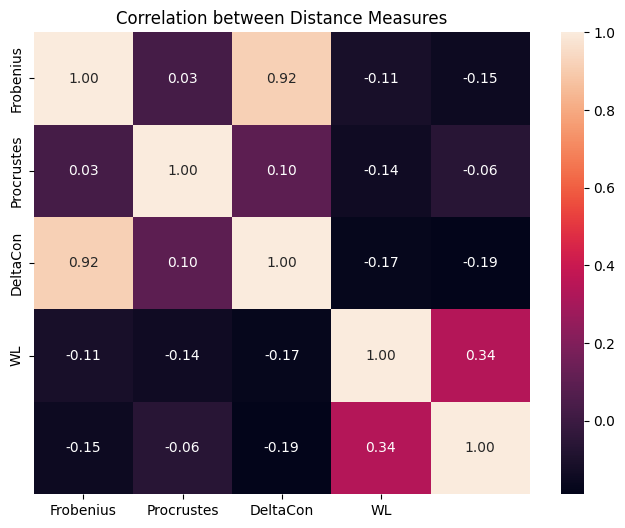

In [8]:
# Calculate correlations between distances
distance_matrix = np.array([
    results['Frobenius'],
    results['Procrustes'],
    results['DeltaCon'],
    results['WL'],
    results['Eigen'],
]).T

correlation_matrix = np.corrcoef(distance_matrix.T)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            xticklabels=['Frobenius', 'Procrustes', 'DeltaCon', 'WL'],
            yticklabels=['Frobenius', 'Procrustes', 'DeltaCon', 'WL'])
plt.title('Correlation between Distance Measures')
plt.show()

# Same Family

In [6]:
n_nodes = 100
n_experiments = 20

def calculate_distances(G1, G2):
    """Calculate all distances between two graphs"""
    A1 = nx.to_numpy_array(G1)
    A2 = nx.to_numpy_array(G2)
    
    return {
        'Frobenius': distance_frobenius(A1, A2),
        'Procrustes': distance_procrustes_LE(A1, A2, k=10),
        'DeltaCon': DeltaConDistance(A1, A2),
        'WL': WL_distance(A1, A2, n_iter=5),
        'Eigen': distance_eigen(A1, A2),
    }

# Initialize results
results = {
    'Distance': [],
    'Value': [],
    'Comparison': [],
    'Model': []
}

# Define graph models and their parameters
graph_models = {
    'Erdos-Renyi': {
        'similar': [(0.3, 0.31)],  # (p1, p2) pairs
        'dissimilar': [(0.2, 0.8)],
        'generator': lambda p: nx.erdos_renyi_graph(n_nodes, p)
    },
    'Watts-Strogatz': {
        'similar': [(0.1, 0.12)],  # (beta1, beta2) pairs with k=4
        'dissimilar': [(0.1, 0.9)],
        'generator': lambda beta: nx.watts_strogatz_graph(n_nodes, 4, beta)
    },
    'Barabasi-Albert': {
        'similar': [(3, 4)],  # (m1, m2) pairs
        'dissimilar': [(2, 10)],
        'generator': lambda m: nx.barabasi_albert_graph(n_nodes, m)
    },
    'Stochastic-Block': {
        'similar': [(0.3, 0.1, 0.31, 0.11)],  # (p_in1, p_out1, p_in2, p_out2)
        'dissimilar': [(0.3, 0.1, 0.8, 0.6)],
        'generator': lambda p_in, p_out: nx.stochastic_block_model(
            sizes=[n_nodes//2, n_nodes//2],
            p=[[p_in, p_out], [p_out, p_in]]
        )
    }
}

In [10]:
# Run experiments
for model_name, model_info in graph_models.items():
    print(f"Processing {model_name}...")
    
    # Similar graphs
    for params in model_info['similar']:
        for _ in range(n_experiments):
            if model_name == 'Stochastic-Block':
                G1 = model_info['generator'](params[0], params[1])
                G2 = model_info['generator'](params[2], params[3])
            else:
                G1 = model_info['generator'](params[0])
                G2 = model_info['generator'](params[1])
            
            distances = calculate_distances(G1, G2)
            for dist_name, value in distances.items():
                results['Distance'].append(dist_name)
                results['Value'].append(value)
                results['Comparison'].append('Similar')
                results['Model'].append(model_name)
    
    # Dissimilar graphs
    for params in model_info['dissimilar']:
        for _ in range(n_experiments):
            if model_name == 'Stochastic-Block':
                G1 = model_info['generator'](params[0], params[1])
                G2 = model_info['generator'](params[2], params[3])
            else:
                G1 = model_info['generator'](params[0])
                G2 = model_info['generator'](params[1])
            
            distances = calculate_distances(G1, G2)
            for dist_name, value in distances.items():
                results['Distance'].append(dist_name)
                results['Value'].append(value)
                results['Comparison'].append('Dissimilar')
                results['Model'].append(model_name)

# Convert to DataFrame
df = pd.DataFrame(results)
with open(f'results_same_family.pkl', 'wb') as f:
    pickle.dump(df, f)


Processing Erdos-Renyi...


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Processing Watts-Strogatz...
Processing Barabasi-Albert...
Processing Stochastic-Block...


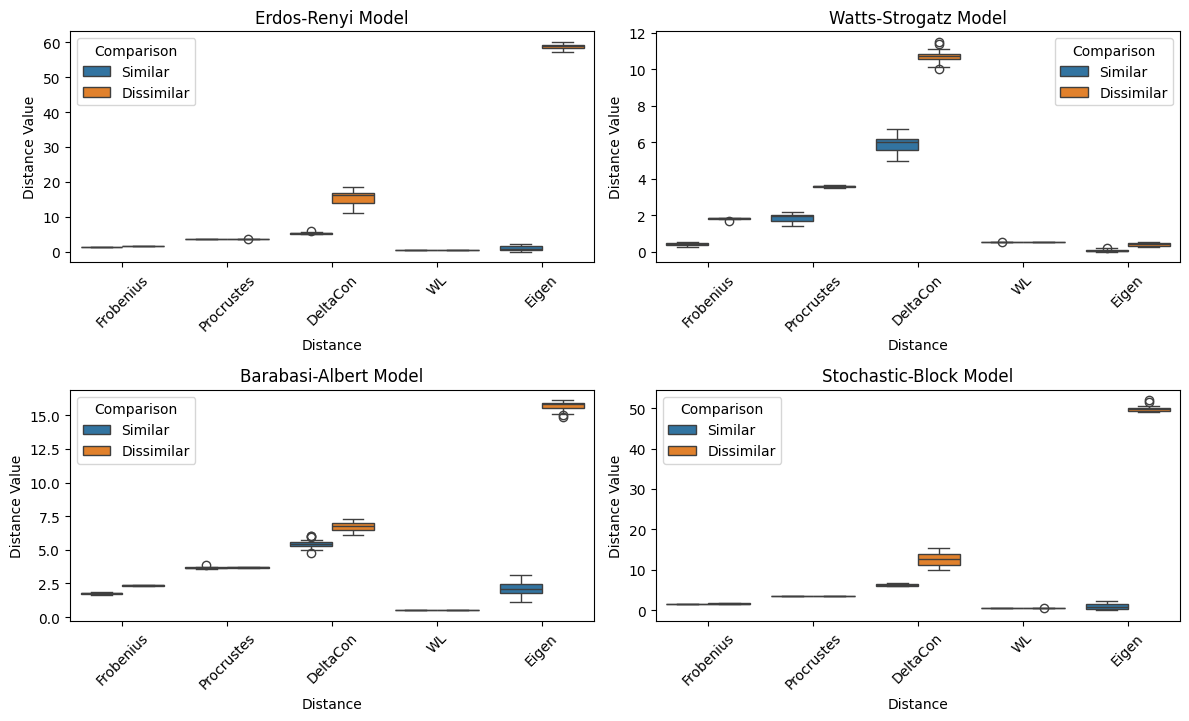


Average distances for each model and comparison:
Comparison                   Dissimilar   Similar
Model            Distance                        
Barabasi-Albert  DeltaCon      6.728319  5.458970
                 Eigen        15.680876  2.115899
                 Frobenius     2.355714  1.757203
                 Procrustes    3.685607  3.679754
                 WL            0.548199  0.529749
Erdos-Renyi      DeltaCon     15.432017  5.287147
                 Eigen        58.726765  0.931869
                 Frobenius     1.692094  1.383984
                 Procrustes    3.672569  3.658758
                 WL            0.528201  0.511342
Stochastic-Block DeltaCon     12.470245  6.211136
                 Eigen        49.829388  0.891514
                 Frobenius     1.613517  1.490388
                 Procrustes    3.534551  3.519858
                 WL            0.527976  0.511503
Watts-Strogatz   DeltaCon     10.735016  5.923862
                 Eigen         0.397186  0.076652


In [7]:
import pickle
with open(f'results_same_family.pkl', 'rb') as f:
    df = pickle.load(f)

# Create plots
plt.figure(figsize=(12, 10))
for i, model in enumerate(graph_models.keys(), 1):
    plt.subplot(3, 2, i)
    model_data = df[df['Model'] == model]
    
    sns.boxplot(data=model_data, x='Distance', y='Value', hue='Comparison')
    plt.title(f'{model} Model')
    plt.xticks(rotation=45)
    plt.ylabel('Distance Value')
    
plt.tight_layout()
plt.show()

# Calculate and display average distances
print("\nAverage distances for each model and comparison:")
avg_distances = df.groupby(['Model', 'Distance', 'Comparison'])['Value'].mean().unstack()
print(avg_distances)

# Different Family

In [12]:
n_nodes = 100
n_experiments = 20

def calculate_distances(G1, G2):
    """Calculate all distances between two graphs"""
    A1 = nx.to_numpy_array(G1)
    A2 = nx.to_numpy_array(G2)
    
    return {
        'Frobenius': distance_frobenius(A1, A2),
        'Procrustes': distance_procrustes_LE(A1, A2, k=10),
        'DeltaCon': DeltaConDistance(A1, A2),
        'WL': WL_distance(A1, A2, n_iter=5),
        'Eigen': distance_eigen(A1, A2),
    }

# Initialize results
results = {
    'Distance': [],
    'Value': [],
    'Comparison': [],
    'Model_Pair': []
}

# Define graph generators with their default parameters
graph_generators = {
    'ER': lambda: nx.erdos_renyi_graph(n_nodes, p=0.3),
    'WS': lambda: nx.watts_strogatz_graph(n_nodes, k=4, p=0.1),
    'BA': lambda: nx.barabasi_albert_graph(n_nodes, m=3),
    'SBM': lambda: nx.stochastic_block_model(
        sizes=[n_nodes//2, n_nodes//2],
        p=[[0.3, 0.1], [0.1, 0.3]]
    )
}

# Define similar and dissimilar model pairs
similar_pairs = [
    ('ER', 'SBM'),    # Both have random-like structure
    ('WS', 'ER'),     # Both can have similar clustering when p is small
    ('BA', 'SBM'),    # Both can have hub-like structures
]

dissimilar_pairs = [
    ('BA', 'WS'),     # Scale-free vs regular structure
    ('ER', 'BA'),     # Random vs scale-free
    ('WS', 'SBM'),    # Regular vs community structure
]


In [13]:
# Run experiments
print("Processing similar pairs...")
for model1_name, model2_name in similar_pairs:
    for _ in range(n_experiments):
        G1 = graph_generators[model1_name]()
        G2 = graph_generators[model2_name]()
        
        distances = calculate_distances(G1, G2)
        for dist_name, value in distances.items():
            results['Distance'].append(dist_name)
            results['Value'].append(value)
            results['Comparison'].append('Similar')
            results['Model_Pair'].append(f'{model1_name}-{model2_name}')

print("Processing dissimilar pairs...")
for model1_name, model2_name in dissimilar_pairs:
    for _ in range(n_experiments):
        G1 = graph_generators[model1_name]()
        G2 = graph_generators[model2_name]()
        
        distances = calculate_distances(G1, G2)
        for dist_name, value in distances.items():
            results['Distance'].append(dist_name)
            results['Value'].append(value)
            results['Comparison'].append('Dissimilar')
            results['Model_Pair'].append(f'{model1_name}-{model2_name}')

# Convert to DataFrame
df = pd.DataFrame(results)

with open(f'results_diff_family.pkl', 'wb') as f:
    pickle.dump(df, f)


Processing similar pairs...


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Processing dissimilar pairs...


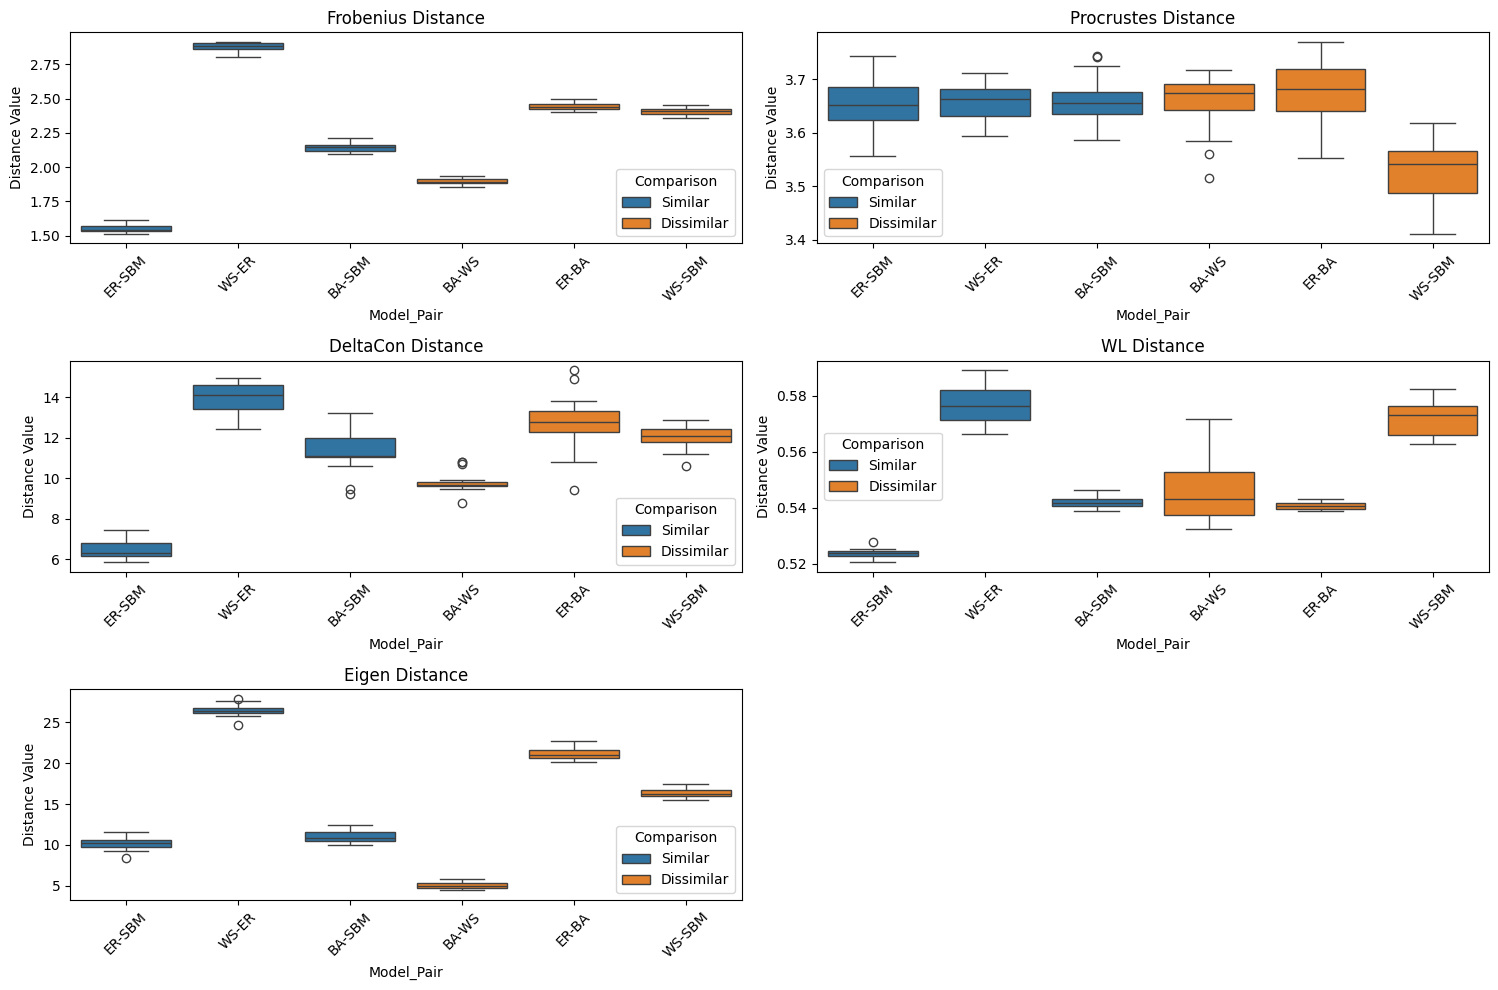


Average distances for each model pair and comparison:
Comparison             Dissimilar    Similar
Model_Pair Distance                         
BA-SBM     DeltaCon           NaN  11.314254
           Eigen              NaN  11.059547
           Frobenius          NaN   2.144569
           Procrustes         NaN   3.660483
           WL                 NaN   0.541899
BA-WS      DeltaCon      9.799841        NaN
           Eigen         5.040134        NaN
           Frobenius     1.900129        NaN
           Procrustes    3.658206        NaN
           WL            0.546613        NaN
ER-BA      DeltaCon     12.667030        NaN
           Eigen        21.128458        NaN
           Frobenius     2.441650        NaN
           Procrustes    3.675667        NaN
           WL            0.540645        NaN
ER-SBM     DeltaCon           NaN   6.514994
           Eigen              NaN  10.184086
           Frobenius          NaN   1.552243
           Procrustes         NaN   3.655028


In [15]:
# Create plots
plt.figure(figsize=(15, 10))

# Plot for each distance measure
for i, distance in enumerate(['Frobenius', 'Procrustes', 'DeltaCon', 'WL', 'Eigen'], 1):
    plt.subplot(3, 2, i)
    distance_data = df[df['Distance'] == distance]
    
    sns.boxplot(data=distance_data, x='Model_Pair', y='Value', hue='Comparison')
    plt.title(f'{distance} Distance')
    plt.xticks(rotation=45)
    plt.ylabel('Distance Value')
    
plt.tight_layout()
plt.show()

# Calculate and display average distances
print("\nAverage distances for each model pair and comparison:")
avg_distances = df.groupby(['Model_Pair', 'Distance', 'Comparison'])['Value'].mean().unstack()
print(avg_distances)



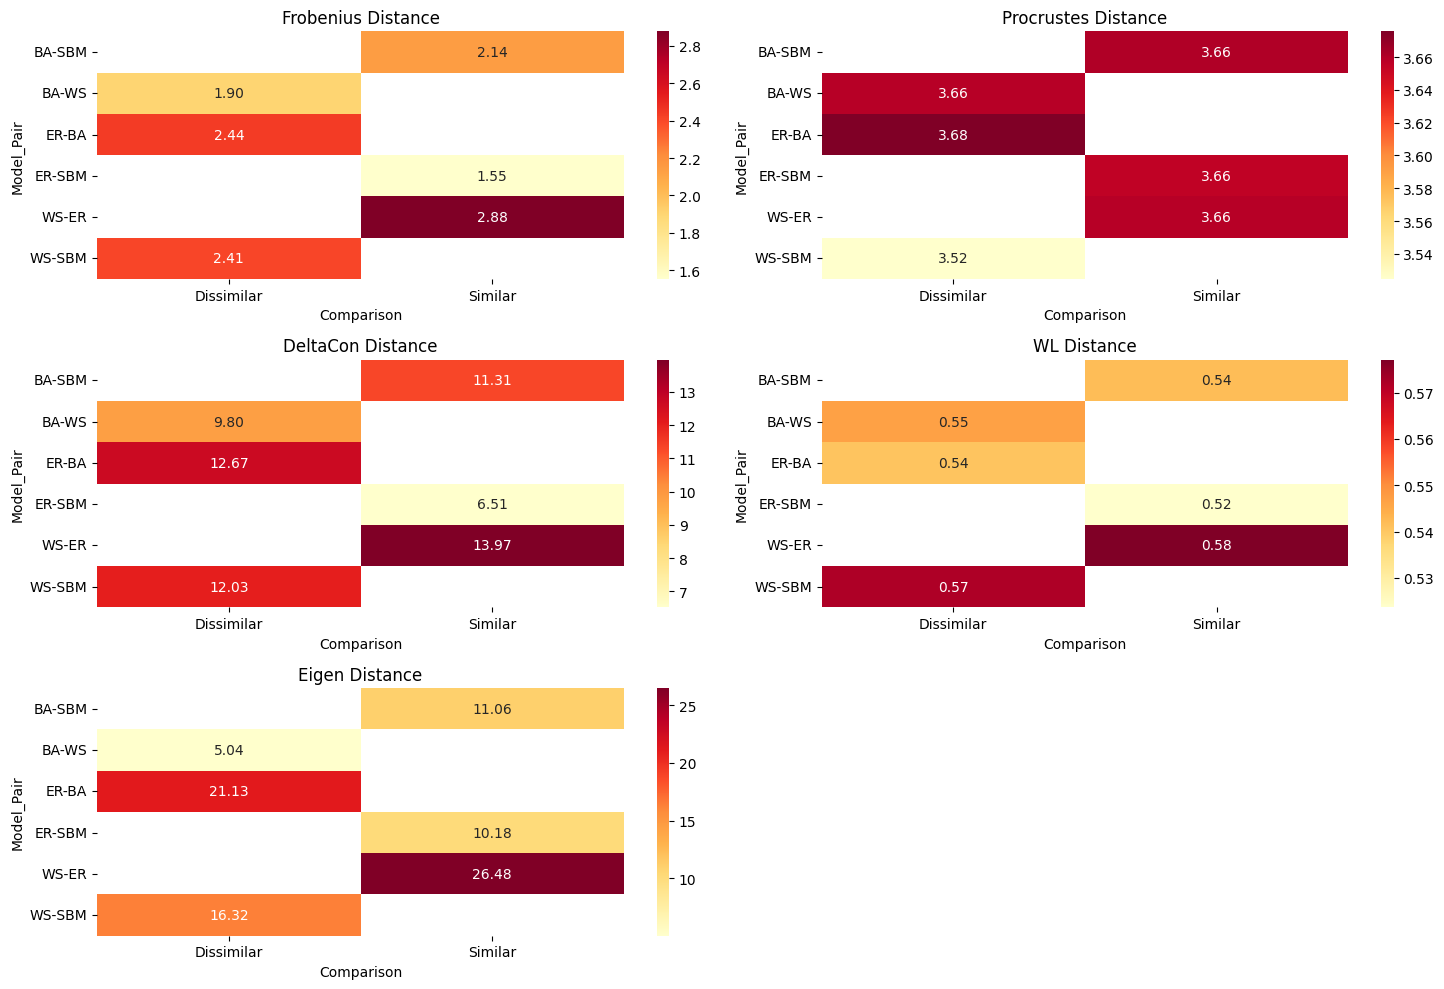

In [16]:
# Create a heatmap of average distances for each measure
plt.figure(figsize=(15, 10))
for i, distance in enumerate(['Frobenius', 'Procrustes', 'DeltaCon', 'WL', 'Eigen'], 1):
    plt.subplot(3, 2, i)
    
    # Prepare data for heatmap
    pivot_data = df[df['Distance'] == distance].pivot_table(
        values='Value',
        index='Model_Pair',
        columns='Comparison',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title(f'{distance} Distance')
    
plt.tight_layout()
plt.show()